The following code should be run in colab envrionment. One should follow the comments and codes in the `Upload files` section to upload `train.csv`, `test.csv` and noisy images. Once the data is uploaded, one should execute codes for `categorical variables classification`, `Logistic regression`, `SVM`, `Decision Tree`, `Noisy Text Classification` and `Image Classification` in order to get three lists of predicted probabilities. Finally, One should execute `Ensemble` section to obtain the final prediction. 

## Import Library

In [ ]:
! pip install --upgrade category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.2/81.2 kB 8.8 MB/s eta 0:00:00


In [ ]:
import io
import pandas as pd
import numpy as np
import category_encoders as ce
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import to_categorical
from keras.preprocessing import image, text
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow_datasets as tfds
import tensorflow as tf
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Uploud files

In [ ]:
# Upload `train.csv` and `test.csv`
from google.colab import files
uploaded = files.upload()

Saving test.csv to test.csv
Saving train.csv to train.csv


In [ ]:
# Upload zipped noisy images
from google.colab import files
uploaded = files.upload()

Saving noisy-images.zip to noisy-images.zip


In [ ]:
# read train and test dataset as pandas dataframe
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [ ]:
# Unzip noisy images
!unzip noisy-images.zip

Streaming output truncated to the last 5000 lines.
  inflating: noisy-images/3212.jpg   
  inflating: __MACOSX/noisy-images/._3212.jpg  
  inflating: noisy-images/11755.jpg  
  inflating: __MACOSX/noisy-images/._11755.jpg  
  inflating: noisy-images/52888.jpg  
  inflating: __MACOSX/noisy-images/._52888.jpg  
  inflating: noisy-images/12274.jpg  
  inflating: __MACOSX/noisy-images/._12274.jpg  
  inflating: noisy-images/44032.jpg  
  inflating: __MACOSX/noisy-images/._44032.jpg  
  inflating: noisy-images/14605.jpg  
  inflating: __MACOSX/noisy-images/._14605.jpg  
  inflating: noisy-images/9071.jpg   
  inflating: __MACOSX/noisy-images/._9071.jpg  
  inflating: noisy-images/52650.jpg  
  inflating: __MACOSX/noisy-images/._52650.jpg  
  inflating: noisy-images/6342.jpg   
  inflating: __MACOSX/noisy-images/._6342.jpg  
  inflating: noisy-images/35813.jpg  
  inflating: __MACOSX/noisy-images/._35813.jpg  
  inflating: noisy-images/10463.jpg  
  inflating: __MACOSX/noisy-images/._10463.j

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


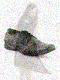

In [ ]:
# visualization of an image
img = tf.keras.preprocessing.image.load_img('noisy-images/42091.jpg')
img

In [ ]:
# list all images
list_ds = tf.data.Dataset.list_files('noisy-images/*', shuffle=False)
image_count = len(list_ds)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

In [ ]:
for f in list_ds.take(5):
  print(f.numpy())

b'noisy-images/52423.jpg'
b'noisy-images/17679.jpg'
b'noisy-images/22142.jpg'
b'noisy-images/37422.jpg'
b'noisy-images/32751.jpg'


## Categorical attributes classification

**1.   Data preprocessing**

Before proceeding with the classification analysis, we preprocess the dataset to ensure its suitability. The following changes are made:

*   **From categorical to numeric**: The package ‘Scikit-learn’ requires categorical features to be encoded as numbers, rather than strings like ‘Women’. There are two types of encoding for categorical data: numeric encoding and “one-hot” encoding. Generally numeric encoding is used when there is an inherent order of the categories, and one-hot encoding otherwise. In our case, we do not have any inherent order in any of our features. Hence, we applied ‘one-hot’ encoding to all of our features. In addition, we numerically encoded `category`

*   **Prepare training and test data**: We split the `train.csv` into training(80%) and testing(20%) where training set contains all categorical variables that are used for model training and testing set contains all categorical variables that are used for validation.

**2. Parameter Tuning**

We applied three classic classification models for categorical attributes classification, namely Logistic Regression, Support Vector Machine and Decision Tree. For each model, we explored various parameters and hyperparameters, and used the Exhaustive Grid Search technique to determine the optimal model for hyperparameter optimization. This involves testing every possible combination of the hyperparameters and determining the best values through cross-validation(k = 10, scoring='accuracy’).

**3. Training, testing and Average probability**

After obtaining the best combination of hyperparameters, we trained each model using the entire `train.csv` and predicted the probabilities using `test.csv`. In the end, we averaged the predicted probabilities from three models and use it as the final categorical_classification_result.

In [ ]:
# One Hot Encoding
gender_encoder=ce.OneHotEncoder(cols='gender',return_df=True,use_cat_names=True)
color_encoder=ce.OneHotEncoder(cols='baseColour',return_df=True,use_cat_names=True)
season_encoder=ce.OneHotEncoder(cols='season',return_df=True,use_cat_names=True)
usage_encoder=ce.OneHotEncoder(cols='usage',return_df=True,use_cat_names=True)
train_df = gender_encoder.fit_transform(train_df)
train_df = color_encoder.fit_transform(train_df)
train_df = season_encoder.fit_transform(train_df)
train_df = usage_encoder.fit_transform(train_df)
test_df = gender_encoder.fit_transform(test_df)
test_df = color_encoder.fit_transform(test_df)
test_df = season_encoder.fit_transform(test_df)
test_df = usage_encoder.fit_transform(test_df)
train_df.head()


,id,category,gender_Men,gender_Women,gender_Girls,gender_Unisex,gender_Boys,baseColour_Tan,baseColour_Blue,baseColour_White,...,season_Winter,season_Spring,usage_Casual,usage_Sports,usage_Formal,usage_Ethnic,usage_Smart Casual,usage_Party,usage_Travel,noisyTextDescription
0,51668,Sandal,1,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,Clarks Men ComfortSoft Wild Sweat Sandals
1,40012,Bottomwear,1,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,John Players Flora Blue Jeans
2,56877,Bottomwear,0,1,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,Scullers For Mud Women White Trousers
3,42598,Shoes,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,Puma Salvation Silly Enigma Black Sports Deerie
4,34629,Topwear,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,Arrow Woman Beige Top


# Logistic Regression

In [ ]:
# data preparation
X = train_df.drop(['category', 'id', 'noisyTextDescription'], axis=1)
y = train_df['category'].astype("category")
y = y.cat.codes
X_train, y_train = X[:int(0.8*len(X))], y[:int(0.8*len(X))]
X_test, y_test = X[int(0.8*len(X)):], y[int(0.8*len(X)):]

In [ ]:
# parameter tuning
param_grid = dict(penalty = ['l1', 'l2', None],
                  C = np.logspace(-3, 3, 7),
                  solver = ['lbfgs', 'liblinear', 'saga'])
print(param_grid)

grid = GridSearchCV(LogisticRegression(), param_grid, cv=10, scoring='accuracy', return_train_score=False)
grid.fit(X_train, y_train)

{'penalty': ['l1', 'l2', None], 'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]), 'solver': ['lbfgs', 'liblinear', 'saga']}


KeyboardInterrupt: ignored

In [ ]:
# parameter tunning result
logistic_result = pd.DataFrame(grid.cv_results_)
logistic_result = logistic_result[-logistic_result['mean_test_score'].isnull()]
logistic_result

NameError: ignored

In [ ]:
print('Best C:', grid.best_estimator_.get_params()['C'])
print('Best Penalty:', grid.best_estimator_.get_params()['penalty'])
print('Best Solver:', grid.best_estimator_.get_params()['solver'])
print('Expected test accuracy:', grid.best_score_)

Best C: 0.001
Best Penalty: None
Best Solver: lbfgs
Expected test accuracy: 0.5375694283173872


In [ ]:
# build the logistic regression model with entire training set
X_train, y_train = X, y
best_logistic_model = LogisticRegression(C=0.001, penalty=None, solver='lbfgs')
best_logistic_model.fit(X_train, y_train)

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=0.001, penalty=None)

In [ ]:
y_hat = best_logistic_model.predict(X_test)

In [ ]:
y_test = np.array(y_test)
correct = 0
for i in range(len(y_test)):
  if y_hat[i] == y_test[i]: correct += 1

correct/len(y_test)

0.5529357374017568

In [ ]:
from sklearn.ensemble import BaggingClassifier
bagged_best_logistic_model = BaggingClassifier(best_logistic_model, max_samples=0.5, max_features=0.5)
bagged_best_logistic_model.fit(X_train, y_train)

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL

BaggingClassifier(estimator=LogisticRegression(C=0.001, penalty=None),
                  max_features=0.5, max_samples=0.5)

In [ ]:
y_hat = bagged_best_logistic_model.predict(X_test)
y_test = np.array(y_test)
correct = 0
for i in range(len(y_test)):
  if y_hat[i] == y_test[i]: correct += 1

correct/len(y_test)

0.540453074433657

In [ ]:
# prediction
X_test = test_df.drop(['id', 'noisyTextDescription'], axis=1)
X_test = X_test[list(X_train.columns)]
logistic_result = best_logistic_model.predict_proba(X_test)

In [ ]:
logistic_result[0]

array([7.40284034e-04, 5.38691719e-05, 2.33992004e-03, 3.21662195e-03,
       9.21464572e-02, 1.65258823e-04, 5.89501493e-06, 1.53913637e-04,
       1.88147798e-02, 3.05074475e-05, 1.97364709e-05, 6.57102893e-03,
       5.38711857e-03, 2.98558866e-04, 3.86321876e-09, 2.73935483e-04,
       8.90931303e-08, 7.44310312e-09, 3.96435449e-02, 3.82942162e-07,
       4.43872016e-03, 1.05717356e-01, 1.55368902e-02, 2.30172922e-03,
       6.97712205e-01, 4.41521141e-03, 1.59749263e-05])

# SVM

In [ ]:
# data preparation
X = train_df.drop(['category', 'id', 'noisyTextDescription'], axis=1)
y = train_df['category'].astype("category")
y = y.cat.codes
X_train, y_train = X[:int(0.8*len(X))], y[:int(0.8*len(X))]
X_test, y_test = X[int(0.8*len(X)):], y[int(0.8*len(X)):]

In [ ]:
# Parameter tuning
model = Pipeline([
    ('scaler', StandardScaler()),
    ('model',  svm.SVC())
])
param_grid = [
  {'model__C': [0.1, 1, 10], 'model__gamma': ['scale', 'auto'], 'model__kernel': ['rbf']},
    {'model__C': [0.1, 1, 10], 'model__degree': [2, 3], 'model__kernel': ['poly']},
    {'model__C': [0.1, 1, 10], 'model__kernel': ['sigmoid']}
 ]
cv = KFold(
    n_splits=5,  # number of folds
    shuffle=True # protects against data being ordered, e.g., all successes first
)

cv_model = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=cv
)

cv_model.fit(X=X_train, y=y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model', SVC())]),
             param_grid=[{'model__C': [0.1, 1, 10],
                          'model__gamma': ['scale', 'auto'],
                          'model__kernel': ['rbf']},
                         {'model__C': [0.1, 1, 10], 'model__degree': [2, 3],
                          'model__kernel': ['poly']},
                         {'model__C': [0.1, 1, 10],
                          'model__kernel': ['sigmoid']}])

In [ ]:
# Parameter tuning result
SVM_result = pd.DataFrame(cv_model.cv_results_)
SVM_result

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__C,param_model__gamma,param_model__kernel,param_model__degree,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,13.991572,0.092345,4.620187,0.330292,0.1,scale,rbf,NaN,"{'model__C': 0.1, 'model__gamma': 'scale', 'mo...",0.516903,0.513006,0.513295,0.500000,0.509827,0.510606,0.005757,9
1,13.915958,0.064793,4.481279,0.081624,0.1,auto,rbf,NaN,"{'model__C': 0.1, 'model__gamma': 'auto', 'mod...",0.516903,0.513006,0.513295,0.500000,0.509827,0.510606,0.005757,9
2,11.574963,0.122858,4.218394,0.271489,1,scale,rbf,NaN,"{'model__C': 1, 'model__gamma': 'scale', 'mode...",0.548396,0.542775,0.550578,0.531214,0.541618,0.542916,0.006744,1
3,11.726517,0.092511,4.152258,0.204331,1,auto,rbf,NaN,"{'model__C': 1, 'model__gamma': 'auto', 'model...",0.548396,0.542775,0.550578,0.531214,0.541618,0.542916,0.006744,1
4,11.429075,0.103446,3.875247,0.039340,10,scale,rbf,NaN,"{'model__C': 10, 'model__gamma': 'scale', 'mod...",0.540595,0.541329,0.547110,0.535260,0.546532,0.542165,0.004344,4
5,11.237612,0.099336,4.021727,0.139727,10,auto,rbf,NaN,"{'model__C': 10, 'model__gamma': 'auto', 'mode...",0.540595,0.541329,0.547110,0.535260,0.546532,0.542165,0.004344,4
6,13.797540,0.491631,3.314078,0.027907,0.1,NaN,poly,2,"{'model__C': 0.1, 'model__degree': 2, 'model__...",0.476163,0.482370,0.489017,0.465318,0.481503,0.478874,0.007914,13
7,14.437632,0.312434,3.361655,0.054993,0.1,NaN,poly,3,"{'model__C': 0.1, 'model__degree': 3, 'model__...",0.436868,0.451734,0.449711,0.439884,0.446821,0.445004,0.005712,15
8,11.095781,0.091640,2.919618,0.048660,1,NaN,poly,2,"{'model__C': 1, 'model__degree': 2, 'model__ke...",0.542329,0.540462,0.547399,0.535260,0.542197,0.541529,0.003898,7
9,12.213318,0.083027,3.021442,0.039423,1,NaN,poly,3,"{'model__C': 1, 'model__degree': 3, 'model__ke...",0.534528,0.534393,0.543642,0.530636,0.542775,0.537195,0.005112,8


In [ ]:
cv_model.best_estimator_.get_params()

{'memory': None,
 'steps': [('scaler', StandardScaler()), ('model', SVC(C=1))],
 'verbose': False,
 'scaler': StandardScaler(),
 'model': SVC(C=1),
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'model__C': 1,
 'model__break_ties': False,
 'model__cache_size': 200,
 'model__class_weight': None,
 'model__coef0': 0.0,
 'model__decision_function_shape': 'ovr',
 'model__degree': 3,
 'model__gamma': 'scale',
 'model__kernel': 'rbf',
 'model__max_iter': -1,
 'model__probability': False,
 'model__random_state': None,
 'model__shrinking': True,
 'model__tol': 0.001,
 'model__verbose': False}

In [ ]:
# Build the model with entire training set
X_train, y_train = X, y
best_SVM_model = svm.SVC(C=1, kernel='rbf', gamma='scale', probability=True)
best_SVM_model.fit(X_train, y_train)

SVC(C=1, probability=True)

In [ ]:
# prediction
X_test = test_df.drop(['id', 'noisyTextDescription'], axis=1)
X_test = X_test[list(X_train.columns)]
SVM_result = best_SVM_model.predict_proba(X_test)

# Decision Tree

In [ ]:
# data preparation
X = train_df.drop(['category', 'id', 'noisyTextDescription'], axis=1)
y = train_df['category'].astype("category")
y = y.cat.codes
X_train, y_train = X[:int(0.8*len(X))], y[:int(0.8*len(X))]
X_test, y_test = X[int(0.8*len(X)):], y[int(0.8*len(X)):]

In [ ]:
# Parameter tuning
param_grid = dict(criterion = ['gini', 'entropy'],
                  max_depth = [4,6,8,10,12],
                  min_samples_leaf = range(2, 5),
                  min_samples_split = range(2, 5))
print(param_grid)

grid = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=10, scoring='accuracy', return_train_score=False)
grid.fit(X_train, y_train)

{'criterion': ['gini', 'entropy'], 'max_depth': [4, 6, 8, 10, 12], 'min_samples_leaf': range(2, 5), 'min_samples_split': range(2, 5)}


KeyboardInterrupt: ignored

In [ ]:
# Parameter tuning result
DT_result = pd.DataFrame(grid.cv_results_)
DT_result

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.018450,0.000902,0.002227,0.000218,gini,4,2,2,"{'criterion': 'gini', 'max_depth': 4, 'min_sam...",0.484113,...,0.485549,0.478613,0.475723,0.480925,0.483815,0.473988,0.473410,0.478585,0.005331,73
1,0.018738,0.000812,0.002143,0.000082,gini,4,2,3,"{'criterion': 'gini', 'max_depth': 4, 'min_sam...",0.484113,...,0.485549,0.478613,0.475723,0.480925,0.483815,0.473988,0.473410,0.478585,0.005331,73
2,0.017649,0.000355,0.002203,0.000111,gini,4,2,4,"{'criterion': 'gini', 'max_depth': 4, 'min_sam...",0.484113,...,0.485549,0.478613,0.475723,0.480925,0.483815,0.473988,0.473410,0.478585,0.005331,73
3,0.018592,0.000626,0.002152,0.000129,gini,4,3,2,"{'criterion': 'gini', 'max_depth': 4, 'min_sam...",0.484113,...,0.485549,0.478613,0.475723,0.480925,0.483815,0.473988,0.473410,0.478585,0.005331,73
4,0.018905,0.001375,0.002117,0.000118,gini,4,3,3,"{'criterion': 'gini', 'max_depth': 4, 'min_sam...",0.484113,...,0.485549,0.478613,0.475723,0.480925,0.483815,0.473988,0.473410,0.478585,0.005331,73
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,0.032430,0.000356,0.002151,0.000088,entropy,12,3,3,"{'criterion': 'entropy', 'max_depth': 12, 'min...",0.537262,...,0.535838,0.528324,0.514451,0.538728,0.538150,0.528902,0.530058,0.530027,0.007794,4
86,0.032226,0.000383,0.002119,0.000063,entropy,12,3,4,"{'criterion': 'entropy', 'max_depth': 12, 'min...",0.537262,...,0.535838,0.528324,0.514451,0.538150,0.538150,0.528902,0.530058,0.529969,0.007732,5
87,0.032440,0.001068,0.002173,0.000144,entropy,12,4,2,"{'criterion': 'entropy', 'max_depth': 12, 'min...",0.534951,...,0.535260,0.528324,0.513295,0.537572,0.536994,0.528324,0.532370,0.529738,0.007542,9
88,0.032882,0.000629,0.002197,0.000114,entropy,12,4,3,"{'criterion': 'entropy', 'max_depth': 12, 'min...",0.534951,...,0.535260,0.528324,0.513295,0.538150,0.536994,0.528324,0.532370,0.529796,0.007604,7


In [ ]:
print('Best criterion:', grid.best_estimator_.get_params()['criterion'])
print('Best max_depth:', grid.best_estimator_.get_params()['max_depth'])
print('Best min_samples_leaf:', grid.best_estimator_.get_params()['min_samples_leaf'])
print('Best min_samples_split:', grid.best_estimator_.get_params()['min_samples_split'])
print('Best mean test error:', grid.best_score_)

Best criterion: entropy
Best max_depth: 12
Best min_samples_leaf: 2
Best min_samples_split: 2
Best mean test error: 0.5306625192427779


In [ ]:
# Building the model
X_train, y_train = X, y
best_DT_model = DecisionTreeClassifier(criterion='entropy', max_depth=12, min_samples_leaf=2, min_samples_split=2)
best_DT_model.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=12, min_samples_leaf=2)

In [ ]:
y_hat = best_DT_model.predict(X_test)
y_test = np.array(y_test)
correct = 0
for i in range(len(y_test)):
  if y_hat[i] == y_test[i]: correct += 1

correct/len(y_test)

0.5580212667591309

In [ ]:
from sklearn.ensemble import RandomForestClassifier
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
#grid = GridSearchCV(RandomForestClassifier(), random_grid, cv=10, scoring='accuracy', return_train_score=False)
#grid.fit(X_train, y_train)
RF_model = RandomForestClassifier(n_estimators=10, max_depth=None, min_samples_split=2, min_samples_leaf = 1, random_state=0)
RF_model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=10, random_state=0)

In [ ]:
# prediction
X_test = test_df.drop(['id', 'noisyTextDescription'], axis=1)
X_test = X_test[list(X_train.columns)]
RF_result = RF_model.predict_proba(X_test)
y_hat = np.argmax(DT_result, axis = 1)

In [ ]:
categorical_result = (0.1*logistic_result + RF_result + 0.1*SVM_result)

# Adaboost

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

Adaboost_model = AdaBoostClassifier(
    best_DT_model,
    n_estimators=300,
    learning_rate=0.001,
    algorithm="SAMME",
)
Adaboost_model.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(criterion='entropy',
                                                    max_depth=12,
                                                    min_samples_leaf=2),
                   learning_rate=0.001, n_estimators=300)

In [ ]:
y_hat = Adaboost_model.predict(X_test)
y_test = np.array(y_test)
correct = 0
for i in range(len(y_test)):
  if y_hat[i] == y_test[i]: correct += 1

correct/len(y_test)

0.5494683310217291

# Noisy Text Classification

**1.   Data preparation**

*   **Text Cleaning**

We splitted each noisy text description into a list of tokens, made everything lowercase and removed tokens containing numbers.

*   **From categorical to numeric**: We first numerically encoded `category` and then convert the numeric value into a one-hot tensor of length 27 which refers to the number of distinct categories.

*   **Prepare training and test data**: We split `train.csv` into training(80%) and testing(20%) where `train_X` and `train_y` are the noisy text description and corresponding category for model training, while `test_X` is the noisy text description for validation.

*   **Tokenization and Padding**

In this step, we tokenized the textual description into a sequence of integers using the Tokenizer provided by Keras. We used the training set descrition alone to build a vocabulary of tokens, and use them to convert all the descriptions into a (padded) sequence of tokens. We performed same tokenization on testing set.

**2. Implement a tranformer layer**

**3. Implement two embeeding layers**

One is for token embedding and the other one is for position embedding.

**4. Create a classifier model**

We started by declaring the embedding size for each token, the number of attention heads and the hidden layer size in feed forward network inside transformer. Then we embedded the tokenized input and pass the embedded result through a transformer block. Finally, we have a global average pooling layer, a dropout, and a dense layer to return the probabilities of falling into different categories.

**5. compiling and fitting the model**

We compiled the transformer model with `Adam` as the optimizer, `categorical_crossentropy` as the loss function and `accuracy` as the metric. We then proceeded to fit the model and train it for a couple of epochs.

**6. prediction**

Finally, we trained the transformer model using the entire `train.csv` and predicted the probabilities using `test.csv`. This is the text_classification_result.


In [ ]:
import re
X = train_df['noisyTextDescription']
y = train_df['category'].astype("category")
y = y.cat.codes
y = tf.one_hot(y, 27)

# text cleaning
for ind in range(len(X)):
  tokens = X[ind].split()
  new_tokens = []
  for token in tokens:
    if bool(re.search(r'\d', token)) == True: continue
    else:new_tokens.append(token.lower())
  X[ind]=' '.join(new_tokens)

X_train, y_train = X[:int(0.8*len(X))], y[:int(0.8*len(X))]
X_test, y_test = X[int(0.8*len(X)):], y[int(0.8*len(X)):]

X_test_kaggle = test_df['noisyTextDescription']
for ind in range(len(X_test_kaggle)):
  tokens = X_test_kaggle[ind].split()
  new_tokens = []
  for token in tokens:
    if bool(re.search(r'\d', token)) == True: continue
    else:new_tokens.append(token.lower())
  X_test_kaggle[ind]=' '.join(new_tokens)

<ipython-input-102-23c3b83809d7>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[ind]=' '.join(new_tokens)
<ipython-input-102-23c3b83809d7>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_kaggle[ind]=' '.join(new_tokens)


In [ ]:
train_X = np.array(X_train)

## Hyperparameters fot tokenizer
vocab_size = 1000
maxlen = 10

## tokenizer
tokenizer = keras.preprocessing.text.Tokenizer(num_words=vocab_size)
## fit tokenizer
tokenizer.fit_on_texts(train_X)
## text to sequences
texts_to_int = tokenizer.texts_to_sequences(train_X)
## pad sequences
texts_to_int_pad = keras.utils.pad_sequences(texts_to_int, maxlen=maxlen, truncating='pre', padding='pre')

In [ ]:
## X and y for train and val
x_train = texts_to_int_pad
#y_train = labels


## Perform same vectorization on testing set
x_val_text = np.array(X_test)

x_val = keras.utils.pad_sequences(
    tokenizer.texts_to_sequences(x_val_text),
    maxlen=maxlen,
    truncating='pre',
    padding='pre'
)
    
#y_val = np.array([1 if l == 'pos' else 0 for (t, l) in test_set])
y_val = y_test
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

(17301, 10)
(17301, 27)
(4326, 10)
(4326, 27)


In [ ]:
# Implement a Transformer block as a layer
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.25):
        super(TransformerBlock, self).__init__()
        self.att = tf.keras.layers.MultiHeadAttention(num_heads=num_heads,
                                             key_dim=embed_dim)
        self.ffn = keras.Sequential([
            tf.keras.layers.Dense(ff_dim, activation="relu"),
            tf.keras.layers.Dense(embed_dim),
        ])
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)  # self-attention layer
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)  # layer norm
        ffn_output = self.ffn(out1)  #feed-forward layer
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)  # layer norm

# Implement two embedding layers, one for token embedding, one for position embedding
class TokenAndPositionEmbedding(tf.keras.layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = tf.keras.layers.Embedding(input_dim=vocab_size,
                                          output_dim=embed_dim)
        self.pos_emb = tf.keras.layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [ ]:
embed_dim = 64  # Embedding size for each token
num_heads = 1  # Number of attention heads
ff_dim = 256  # Hidden layer size in feed forward network inside transformer

## Using Sequential API
model = keras.Sequential()
model.add(tf.keras.Input(shape=(maxlen, )))
model.add(TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim))
model.add(TransformerBlock(embed_dim, num_heads, ff_dim))
model.add(tf.keras.layers.GlobalMaxPool1D())
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(ff_dim, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(27, activation='softmax'))

model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

history = model.fit(x_train,
                    y_train,
                    batch_size=64,
                    epochs=8,
                    validation_data=(x_val, y_val))

Epoch 1/8
271/271 [==============================] - 19s 40ms/step - loss: 2.0841 - accuracy: 0.4566 - val_loss: 1.4140 - val_accuracy: 0.6718
Epoch 2/8
271/271 [==============================] - 4s 14ms/step - loss: 1.4775 - accuracy: 0.6542 - val_loss: 1.1278 - val_accuracy: 0.7531
Epoch 3/8
271/271 [==============================] - 2s 9ms/step - loss: 1.2431 - accuracy: 0.7249 - val_loss: 1.0449 - val_accuracy: 0.7751
Epoch 4/8
271/271 [==============================] - 3s 10ms/step - loss: 1.1110 - accuracy: 0.7624 - val_loss: 1.0454 - val_accuracy: 0.7862
Epoch 5/8
271/271 [==============================] - 3s 11ms/step - loss: 1.0450 - accuracy: 0.7806 - val_loss: 1.0800 - val_accuracy: 0.7873
Epoch 6/8
271/271 [==============================] - 2s 8ms/step - loss: 1.0010 - accuracy: 0.7918 - val_loss: 1.0747 - val_accuracy: 0.7878
Epoch 7/8
271/271 [==============================] - 3s 9ms/step - loss: 0.9635 - accuracy: 0.7995 - val_loss: 1.0846 - val_accuracy: 0.7841
Epoch 8/

In [ ]:
# refit the model with entire training set
x_train, y_train = X, y
train_X = np.array(x_train)
## fit tokenizer
tokenizer.fit_on_texts(train_X)
## text to sequences
texts_to_int = tokenizer.texts_to_sequences(train_X)
## pad sequences
texts_to_int_pad = keras.utils.pad_sequences(texts_to_int, maxlen=maxlen, truncating='pre', padding='pre')
x_train = texts_to_int_pad

model.fit(x_train, y_train, batch_size=64, epochs=8)

Epoch 1/8
338/338 [==============================] - 3s 7ms/step - loss: 1.4209 - accuracy: 0.6530
Epoch 2/8
338/338 [==============================] - 2s 7ms/step - loss: 1.0716 - accuracy: 0.7648
Epoch 3/8
338/338 [==============================] - 2s 7ms/step - loss: 0.9934 - accuracy: 0.7885
Epoch 4/8
338/338 [==============================] - 2s 7ms/step - loss: 0.9546 - accuracy: 0.8002
Epoch 5/8
338/338 [==============================] - 2s 7ms/step - loss: 0.9297 - accuracy: 0.8065
Epoch 6/8
338/338 [==============================] - 3s 8ms/step - loss: 0.9100 - accuracy: 0.8084
Epoch 7/8
338/338 [==============================] - 3s 8ms/step - loss: 0.8921 - accuracy: 0.8130
Epoch 8/8
338/338 [==============================] - 3s 8ms/step - loss: 0.8744 - accuracy: 0.8176


In [ ]:
# prediction
x_val_text = np.array(X_test_kaggle)
x_val = keras.utils.pad_sequences(
    tokenizer.texts_to_sequences(x_val_text),
    maxlen=maxlen,
    truncating='pre',
    padding='pre'
)

text_classification_result = model.predict(x_val)

676/676 [==============================] - 2s 3ms/step


# image classification

**1.   Data preparation**

*   **From categorical to numeric**: We first numerically encoded `category` and then convert the numeric value into a one-hot tensor of length 27 which refers to the number of distinct categories.

*   **Prepare training and test data**: We splitted `train.csv` into training(80%) and testing(20%) where `train_X` and `train_y` are the image paths and corresponding category for model training, while `test_X` is the images path for validation.

*   **Load images and convert to arrays**: With the image path, we are able to load images into PIL format and then convert them into Numpy arrays.

*   **Standardize data**: The RGB channel values are in the [0, 255] range. This is not ideal for a neural network. Thus, we divided arrays we obtained in previous step by 255 to be in the [0, 1] range.

**2. Create a classifier model**

We cerated a Keras Sequential model consisting of three convolution blocks (`tf.keras.layers.Conv2D`) with a max pooling layer (`tf.keras.layers.MaxPooling2D`) and a dropout layer of rate 0.1 (`tf.keras.layers.Dropout`) in each of them. There is a fully-connected layer (`tf.keras.layers.Dense`) with 256 units on top of it that is activated by a ReLU activation function ('relu'). 

**3. compiling and fitting the model**

We compiled the CNN model with `Adam` as the optimizer, `categorical_crossentropy` as the loss function and `accuracy` as the metric. We then proceeded to fit the model and train it for a couple of epochs.

**4. prediction**

Finally, we trained the CNN model using the entire `train.csv` and predicted the probabilities using `test.csv`. This is the `image_classification_result`.

In [ ]:
train_df.head()

,id,category,gender_Men,gender_Women,gender_Girls,gender_Unisex,gender_Boys,baseColour_Tan,baseColour_Blue,baseColour_White,...,season_Winter,season_Spring,usage_Casual,usage_Sports,usage_Formal,usage_Ethnic,usage_Smart Casual,usage_Party,usage_Travel,noisyTextDescription
0,51668,Sandal,1,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,Clarks Men ComfortSoft Wild Sweat Sandals
1,40012,Bottomwear,1,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,John Players Flora Blue Jeans
2,56877,Bottomwear,0,1,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,Scullers For Mud Women White Trousers
3,42598,Shoes,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,Puma Salvation Silly Enigma Black Sports Deerie
4,34629,Topwear,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,Arrow Woman Beige Top


In [ ]:
indices = train_df['id']
y = train_df['category'].astype("category")
dic = dict(enumerate(y.cat.categories))
y = y.cat.codes
y = tf.one_hot(y, 27)
indices_train, y_train = indices[:int(0.8*len(y))], y[:int(0.8*len(y))]
indices_test, y_test = indices[int(0.8*len(y)):], y[int(0.8*len(y)):]
indices_kaggle = test_df['id']

In [ ]:
train_image = []
for index in indices_train:
    img = tf.keras.utils.load_img('noisy-images/' + str(index) + '.jpg', target_size=(60,80,1))
    img = tf.keras.utils.img_to_array(img)
    img = img/255
    train_image.append(img)
X_train = np.array(train_image)

test_image = []
for index in indices_test:
    img = tf.keras.utils.load_img('noisy-images/' + str(index) + '.jpg', target_size=(60,80,1))
    img = tf.keras.utils.img_to_array(img)
    img = img/255
    test_image.append(img)
X_test = np.array(test_image)

test_image_kaggle = []
for index in indices_kaggle:
    img = tf.keras.utils.load_img('noisy-images/' + str(index) + '.jpg', target_size=(60,80,1))
    img = tf.keras.utils.img_to_array(img)
    img = img/255
    test_image_kaggle.append(img)

In [ ]:
X_train[0].shape

(60, 80, 3)

In [ ]:
train_y = np.array(y_train)
test_y = np.array(y_test)
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, train_y))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, test_y))

In [ ]:
for image, label in train_dataset.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (60, 80, 3)
Label:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 0.]


In [ ]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
for image_batch, labels_batch in train_dataset:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(64, 60, 80, 3)
(64, 27)


In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, 3, activation='relu', padding = 'same'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Conv2D(32, 3, activation='relu', padding = 'same'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Conv2D(32, 3, activation='relu', padding = 'same'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(27, activation='softmax')
])

model.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])
model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
271/271 [==============================] - 10s 13ms/step - loss: 1.5848 - accuracy: 0.6046 - val_loss: 1.1999 - val_accuracy: 0.7167
Epoch 2/10
271/271 [==============================] - 3s 11ms/step - loss: 1.1349 - accuracy: 0.7379 - val_loss: 1.0747 - val_accuracy: 0.7516
Epoch 3/10
271/271 [==============================] - 3s 11ms/step - loss: 1.0210 - accuracy: 0.7678 - val_loss: 1.0344 - val_accuracy: 0.7818
Epoch 4/10
271/271 [==============================] - 3s 11ms/step - loss: 0.9636 - accuracy: 0.7864 - val_loss: 1.0029 - val_accuracy: 0.7781
Epoch 5/10
271/271 [==============================] - 3s 11ms/step - loss: 0.9124 - accuracy: 0.7941 - val_loss: 0.9971 - val_accuracy: 0.7922
Epoch 6/10
271/271 [==============================] - 3s 11ms/step - loss: 0.8702 - accuracy: 0.8019 - val_loss: 0.9905 - val_accuracy: 0.7781
Epoch 7/10
271/271 [==============================] - 3s 11ms/step - loss: 0.8254 - accuracy: 0.8106 - val_loss: 0.9809 - val_accuracy: 0.787

In [ ]:
indices_train, y_train = indices, y

#train_file_path = []
#for index in indices_train:
#  train_file_path.append('noisy-images/' + str(index) + '.jpg')

#train_ds = tf.data.Dataset.list_files(train_file_path, shuffle=False)
#train_ds = train_ds.shuffle(len(train_ds), reshuffle_each_iteration=False)

train_image = []
for index in indices_train:
    img = tf.keras.utils.load_img('noisy-images/' + str(index) + '.jpg', target_size=(60,80,1))
    img = tf.keras.utils.img_to_array(img)
    img = img/255
    train_image.append(img)

X_train = np.array(train_image)
train_y = np.array(y_train)

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, train_y))
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
model.fit(train_dataset, epochs=10)

Epoch 1/10
338/338 [==============================] - 4s 12ms/step - loss: 0.7302 - accuracy: 0.8268
Epoch 2/10
338/338 [==============================] - 4s 11ms/step - loss: 0.6822 - accuracy: 0.8331
Epoch 3/10
338/338 [==============================] - 4s 11ms/step - loss: 0.6369 - accuracy: 0.8434
Epoch 4/10
338/338 [==============================] - 4s 11ms/step - loss: 0.5935 - accuracy: 0.8504
Epoch 5/10
338/338 [==============================] - 4s 11ms/step - loss: 0.5493 - accuracy: 0.8556
Epoch 6/10
338/338 [==============================] - 4s 11ms/step - loss: 0.5134 - accuracy: 0.8615
Epoch 7/10
338/338 [==============================] - 4s 11ms/step - loss: 0.4672 - accuracy: 0.8692
Epoch 8/10
338/338 [==============================] - 4s 11ms/step - loss: 0.4328 - accuracy: 0.8772
Epoch 9/10
338/338 [==============================] - 4s 10ms/step - loss: 0.3950 - accuracy: 0.8833
Epoch 10/10
338/338 [==============================] - 4s 11ms/step - loss: 0.3641 - accura

In [ ]:
image_classification_result = model.predict(np.array(test_image_kaggle))

676/676 [==============================] - 2s 2ms/step


# Ensemble
Previously, we applied a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. We also tried Adaboost on the decision tree. Since the accuracy is not satisfactory, we decided not to integrate the result.

Now, we have obtained a list of probabilities from each one of Categorical attributes, Noisy text description and Images. In order to ensemble them, we average those probabilities and select the class with highest average probability as the final prediction. Since we have numerically encoded the categories, we now map numeric predictions back to coresponding strings.

In [ ]:
text_classification_result[0]

array([9.3255676e-07, 2.3103050e-04, 3.4788882e-03, 9.5349358e-04,
       9.6428430e-01, 3.2200885e-06, 6.3665310e-04, 1.6521544e-03,
       6.3815975e-04, 4.8572666e-04, 8.4361338e-05, 4.1032507e-04,
       3.9391108e-03, 2.7853102e-05, 3.7859433e-04, 1.4665648e-03,
       5.9734884e-05, 1.5653600e-07, 2.1102033e-04, 2.9128999e-04,
       1.0094722e-05, 4.9014031e-03, 9.9296356e-04, 4.8738111e-05,
       1.2821944e-02, 4.1137260e-04, 1.5799253e-03], dtype=float32)

In [ ]:
image_classification_result[0]

array([5.51277026e-06, 1.88892074e-07, 5.62734762e-03, 1.59465289e-05,
       7.01054752e-01, 1.92880122e-11, 9.38126798e-10, 1.49674327e-06,
       8.56970388e-08, 5.52013235e-09, 2.67556661e-08, 5.99365103e-06,
       7.34067896e-07, 9.70646319e-09, 6.59074658e-06, 3.78481241e-06,
       1.10293927e-11, 9.65702984e-09, 4.12108144e-04, 1.06388775e-07,
       7.51582241e-10, 1.11927732e-03, 2.18355899e-06, 4.17453468e-11,
       2.91734606e-01, 1.42622937e-07, 9.13884196e-06], dtype=float32)

In [ ]:
len(text_classification_result)

21628

In [ ]:
y_hat_ensembled = np.argmax((text_classification_result + image_classification_result + categorical_result)/3, axis=1)
y_hat_ensembled

array([ 4, 18,  2, ..., 25, 24, 24])

In [ ]:
y_pred = []
for i in y_hat_ensembled:
  y_pred.append(dic[i])
y_pred[:5]

['Bottomwear', 'Sandal', 'Bags', 'Shoes', 'Wallets']

In [ ]:
from google.colab import files
uploaded = files.upload()
sample_submission = pd.read_csv('sample_submission.csv')

Saving sample_submission.csv to sample_submission.csv


In [ ]:
sample_submission['category'] = y_pred
sample_submission.head()

,id,category
0,55581,Bottomwear
1,8832,Sandal
2,29112,Bags
3,30961,Shoes
4,49668,Wallets


In [ ]:
from google.colab import drive
drive.mount('drive')
sample_submission.to_csv('submission.csv')
!cp submission.csv "drive/My Drive/"

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).
